# MAP-Elites track generations

In [ ]:
import numpy as np
import requests
import random
import matplotlib.pyplot as plt

import joblib    
# Just load a saved t-SNE or UMAP model     
EMBEDDING_MODEL = joblib.load("EmbeddingModels/umap_model.joblib")   # 2-D model trained offline

from dask.distributed import Client, LocalCluster
from ribs.archives import SlidingBoundariesArchive
from ribs.emitters import EmitterBase
from ribs.schedulers import Scheduler
from ribs.visualize import sliding_boundaries_archive_heatmap

In [ ]:
BASE_URL = 'http://localhost:4242'
POINTS_COUNT = 50
MAX_SELECTED_CELLS = 10
SOLUTION_DIM = POINTS_COUNT * 2 + MAX_SELECTED_CELLS * 2 + 1 
TRACK_SIZE_RANGE = (2, 9)
LENGTH_RANGE = (400, 2000)
ITERATIONS = 1000
ARCHIVE_DIM = 10
INIT_POPULATION = ARCHIVE_DIM * ARCHIVE_DIM 

DEBUG_CROSSOVER = True
DEBUG_MUTATION = True

In [24]:
cluster = LocalCluster(processes=True, n_workers=15, threads_per_worker=1)
client = Client(cluster)

### Helper functions

In [25]:
def generate_solution(iteration):
    print(f"Generating solution for iteration {iteration}")
    try:
        response = requests.post(
            f"{BASE_URL}/generate",
            json={
                "id": iteration + random.random(),
                "mode": "voronoi",
                "trackSize": random.randint(TRACK_SIZE_RANGE[0], TRACK_SIZE_RANGE[1])
            },
            timeout=60
        )
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error generating solution for iteration {iteration}: {e}")
        return None

def solution_to_array(sol):
    if sol is None:
        return None
    arr = np.zeros(SOLUTION_DIM)
    for i, p in enumerate(sol.get("dataSet", [])):
        arr[i * 2] = p.get("x", 0)
        arr[i * 2 + 1] = p.get("y", 0)
    for i, c in enumerate(sol.get("selectedCells", [])):
        if i < MAX_SELECTED_CELLS:
            idx = POINTS_COUNT * 2 + i * 2
            arr[idx] = c.get("x", 0)
            arr[idx + 1] = c.get("y", 0)
    arr[-1] = sol.get("id", 0)
    return arr

def array_to_solution(arr):
    ds = []
    for i in range(0, POINTS_COUNT * 2, 2):
        ds.append({"x": float(arr[i]), "y": float(arr[i+1])})
    sel = []
    for i in range(POINTS_COUNT * 2, SOLUTION_DIM - 1, 2):
        x_val = arr[i]
        y_val = arr[i+1]
        if x_val != 0 or y_val != 0:
            sel.append({"x": float(x_val), "y": float(y_val)})
    return {
        "id": float(arr[-1]),
        "mode": "voronoi",
        "dataSet": ds,
        "selectedCells": sel
    }

def get_fractional_part(x):
    return x - int(x)

def pca_align(points):
    pts = points - points.mean(0)
    u, _, _ = np.linalg.svd(pts, full_matrices=False)
    angle = np.arctan2(u[1, 0], u[0, 0])
    rot = np.array([[np.cos(-angle), -np.sin(-angle)],
                    [np.sin(-angle),  np.cos(-angle)]])
    aligned = pts @ rot.T
    if aligned[0, 0] < 0:
        aligned[:, 0] *= -1
    return aligned

def descriptor_from_track(sol):
    pts = np.array([[p["x"], p["y"]] for p in sol.get("splineVector", [])], dtype=float)
    aligned = pca_align(pts)
    flat = aligned.ravel()
    return EMBEDDING_MODEL.transform(flat[None, :])[0]

def fitness_formula(fit):
    s  = fit["speed_entropy"]
    ov = fit["total_overtakes"]
    error = abs(fit["deltaX"]) + abs(fit["deltaY"])        # use magnitude only
    error = max(error, 1e-3)               # avoid divide-by-zero blow-ups
    return s - error + ov/(error*error) 

def evaluate_solution(sol):
    sol_id = sol.get("id", 0)
    ok = True
    msg = ""
    score = 0
    try:
        r = requests.post(f"{BASE_URL}/evaluate", json=sol, timeout=60)
        r.raise_for_status()
        r_json = r.json()
        fit = r_json.get("fitness", {})
        score = fitness_formula(fit)
        desc = descriptor_from_track(r_json)  
    except Exception as e:
        ok = False
        msg = str(e)
        desc = np.zeros((2,))  # just in case of error

    return sol_id, ok, msg, score, desc



## Genetic operators

In [26]:
class CustomEmitter(EmitterBase):
    def __init__(self, archive, solution_dim, batch_size=10, bounds=None):
        super().__init__(archive, solution_dim=solution_dim, bounds=bounds)
        self.batch_size = batch_size
        self.iteration = 0

    def ask(self):
        self.iteration += 1
        print(f"Emitter.ask() called for iteration {self.iteration}")
        if self.iteration <= INIT_POPULATION:
            out = []
            for _ in range(self.batch_size):
                sol = generate_solution(self.iteration - 1)
                arr = solution_to_array(sol)
                if arr is not None:
                    out.append(arr)
                else:
                    out.append(np.full(SOLUTION_DIM, -9999))
            return np.array(out)
        else:
            if random.random() < 0.5:
                return self.mutate_solutions()
            else:
                return self.crossover_solutions()

    def mutate_solutions(self):
        print(f"Mutating solutions for iteration {self.iteration}")
        parents = self.archive.sample_elites(self.batch_size)
        out = []
        for i in range(self.batch_size):
            arr = parents["solution"][i]
            sol = array_to_solution(arr)
            try:
                response = requests.post(
                    f"{BASE_URL}/mutate",
                    json={
                        "individual": sol,
                        "intensityMutation": 10
                    },
                    timeout=60
                )
                response.raise_for_status()
                mutated = response.json().get("mutated", {})
                frac = get_fractional_part(sol["id"])
                mutated["id"] = self.iteration - 1 + frac
                mutated_arr = solution_to_array(mutated)
                if mutated_arr is not None:
                    out.append(mutated_arr)
                    print(f"Mutated ID={sol['id']} to ID={mutated['id']}")
                else:
                    out.append(np.full(SOLUTION_DIM, -9999))
            except requests.RequestException as e:
                print(f"Error mutating solution ID={sol['id']}: {e}")
                out.append(np.full(SOLUTION_DIM, -9999))
        return np.array(out)

    def crossover_solutions(self):
        print(f"Crossover solutions for iteration {self.iteration}")
        out = []
        for _ in range(self.batch_size // 2):
            try:
                while True:
                    parents = self.archive.sample_elites(2)
                    sol1 = array_to_solution(parents["solution"][0])
                    sol2 = array_to_solution(parents["solution"][1])
                    if sol1["id"] != sol2["id"]:
                        break
                response = requests.post(
                    f"{BASE_URL}/crossover",
                    json={
                        "mode": "voronoi",
                        "parent1": sol1,
                        "parent2": sol2
                    },
                    timeout=60
                )
                response.raise_for_status()
                offspring = response.json().get("offspring", {})
                f1 = get_fractional_part(sol1["id"])
                f2 = get_fractional_part(sol2["id"])
                frac = (f1 + f2) % 1
                child_id = self.iteration - 1 + frac
                child_sol = {
                    "id": child_id,
                    "mode": "voronoi",
                    "trackSize": len(offspring.get("sel", [])),
                    "dataSet": offspring.get("ds", []),
                    "selectedCells": offspring.get("sel", [])
                }
                child_arr = solution_to_array(child_sol)
                if child_arr is not None:
                    out.append(child_arr)
                    print(f"Crossover Parent1 ID={sol1['id']}, Parent2 ID={sol2['id']} => Child ID={child_id}")
                else:
                    out.append(np.full(SOLUTION_DIM, -9999))
            except requests.RequestException as e:
                print(f"Error during crossover: {e}")
                out.append(np.full(SOLUTION_DIM, -9999))
        return np.array(out)

## Illuminating search spaces by mapping elites


In [27]:
ARCHIVE_BINS = 30                               # cells per axis
REMAPPING_EVERY = 200                           # move boundaries every 200 insertions
BUFFER_SIZE = 1000                              # keep last 1000 solutions

archive = SlidingBoundariesArchive(
    solution_dim=SOLUTION_DIM,
    dims=[ARCHIVE_BINS, ARCHIVE_BINS],          # 2-D descriptor space
    ranges=[(-1, 1), (-1, 1)],                  # initial bounds in each dim
    remap_frequency=REMAPPING_EVERY,
    buffer_capacity=BUFFER_SIZE
)

emitter = CustomEmitter(
    archive,
    solution_dim=SOLUTION_DIM,
    batch_size=15,
    bounds=[(0, 600)] * (SOLUTION_DIM - 1) + [(0, float('inf'))]
)

scheduler = Scheduler(archive, [emitter])

def run_map_elites(iters):
    global_best_score = -9999
    global_best_id = None
    for i in range(iters):
        print(f"=== Starting iteration {i+1} ===")
        try:
            sols = scheduler.ask()
            sol_dicts = [array_to_solution(s) for s in sols]
            results = client.map(evaluate_solution, sol_dicts)
            
            gathered = client.gather(results)
            
            obj_list = []
            meas_list = []
            failed_ids = []
            for res in gathered:
                sol_id, success, msg, score, measures = res
                if not success or not np.isfinite(score):
                    print(f"Warning: clamping {score} to -9999 for solution ID={sol_id}, reason: {msg}")
                    score = -9999
                    failed_ids.append(sol_id)
                else:
                    print(f"Solution ID={sol_id} evaluated with score={score:.2f}")
                    # Update global best if necessary
                    if score > global_best_score:
                        global_best_score = score
                        global_best_id = sol_id
                obj_list.append(score)
                meas_list.append(measures)
            
            scheduler.tell(obj_list, meas_list)
            
            batch_best = max(obj_list) if obj_list else -9999
            print(f"Iteration {i+1} ended. Best in batch = {batch_best:.2f}")
            if global_best_id is not None:
                print(f"Global Best Score so far: {global_best_score:.2f} (ID={global_best_id})")
            
            data = archive.data()
            if len(data) > 0:
                arch_obj = data["objective"]
                mean_val = np.mean(arch_obj)
                best_val = np.max(arch_obj)
                cov = archive.stats.coverage
                print(f"Archive size={len(archive)}, Coverage={cov:.3f}, Mean={mean_val:.2f}, Best={best_val:.2f}")
            else:
                print("Archive empty so far")
            
            if failed_ids:
                print(f"Failed evaluations for solution IDs: {failed_ids}")
            
            # Plot every 5 iterations
            if (i + 1) % 5 == 0:
                plt.figure(figsize=(8, 6))
                sliding_boundaries_archive_heatmap(archive, boundary_lw=0.5) 
                plt.title(f"Archive Heat-map – Iteration {i+1}")
                plt.xlabel("UMAP-1")   
                plt.ylabel("UMAP-2")
                plt.tight_layout()
                plt.savefig(f"archive_heatmap_iter_{i+1}.png")
                plt.close()
        
        except Exception as e:
            print(f"Error in iteration {i+1}: {e}")
            raise

In [28]:
run_map_elites(ITERATIONS)

=== Starting iteration 1 ===
Emitter.ask() called for iteration 1
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Solution ID=0.5661585398572271 evaluated with score=8.18
Solution ID=0.2651161645636867 evaluated with score=76.82
Solution ID=0.7341108021429662 evaluated with score=0.99
Solution ID=0.21372625070176543 evaluated with score=-4.01
Solution ID=0.6638342434127479 evaluated with score=1.49
Solution ID=0.17753368998709695 evaluated with score=6.86
Solution ID=0.46543430676715025 evaluated with s

KeyboardInterrupt: 

## Visualize Results

In [30]:
print(f"Final archive size={len(archive)}, Coverage={archive.stats.coverage:.3f}")

Final archive size=587, Coverage=0.652


In [31]:
size      = len(archive)
coverage  = archive.stats.coverage
objs      = archive.data()["objective"]
data      = archive.data()

print(f"Archive size     : {size}")
print(f"Coverage         : {coverage:.3%}")
print(f"Best objective   : {objs.max():.3f}")
print(f"Mean objective   : {objs.mean():.3f}\n")

k = 10                                        # how many to list
for i in range(min(k, size)):
    sol_vec = data["solution"][i]
    sol_id  = sol_vec[-1]                     # float ID
    umap_xy = data["measures"][i]
    print(f"{i+1:2d}. "
          f"ID={sol_id:.17f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")


Archive size     : 587
Coverage         : 65.222%
Best objective   : 2682.341
Mean objective   : 20.593

 1. ID=1.23980447168483221   UMAP=(  0.000,   0.000)
 2. ID=53.60530668498884665   UMAP=(  2.256,   1.568)
 3. ID=258.67761625557238858   UMAP=(  2.489,   2.213)
 4. ID=149.27207516069995563   UMAP=(  2.422,   2.970)
 5. ID=417.54222186424721031   UMAP=(  2.612,   3.349)
 6. ID=391.94628935476686138   UMAP=(  2.396,   3.867)
 7. ID=319.98569178336225605   UMAP=(  2.573,   4.013)
 8. ID=334.94303316103264478   UMAP=(  2.619,   4.329)
 9. ID=370.54222186424721031   UMAP=(  2.549,   4.512)
10. ID=401.56622024818034333   UMAP=(  2.529,   4.695)


 1. ID=370.42933291621750413   dx=  4.517   score=   1.470   UMAP=(  5.483,   5.442)
 2. ID=348.66278600988670178   dx=  4.777   score=   8.832   UMAP=(  5.223,   6.240)
 3. ID=21.37820614473593750   dx=  4.818   score=2350.938   UMAP=(  5.182,   7.697)
 4. ID=18.12641097318162764   dx=  4.991   score=  83.680   UMAP=(  5.009,   5.994)


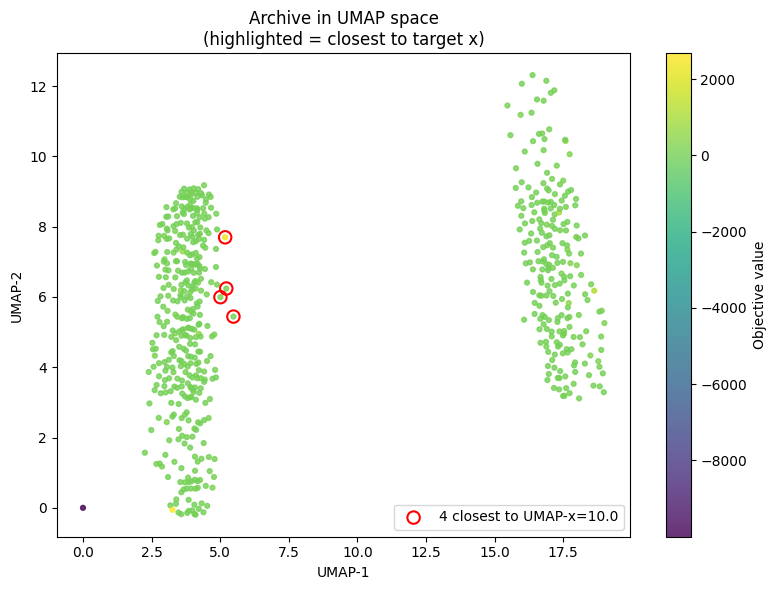

In [32]:
target_x = 10.0   # change this as needed
k        = 4     # how many neighbours to display

measures = data["measures"]                    # (N, 2) array
dx       = np.abs(measures[:, 0] - target_x)   # distance to target on x-axis

nearest_idx = np.argsort(dx)[:k]               # indices of the k closest
for rank, idx in enumerate(nearest_idx, 1):
    sol_vec = data["solution"][idx]
    sol_id  = sol_vec[-1]
    umap_xy = measures[idx]
    score   = objs[idx]
    print(f"{rank:2d}. "
          f"ID={sol_id:.17f}   "
          f"dx={dx[idx]:7.3f}   "
          f"score={score:8.3f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")
    
measures   = data["measures"]            # (N, 2) array of UMAP coordinates
all_x, all_y = measures[:, 0], measures[:, 1]

# colour entire archive by objective score
plt.figure(figsize=(8, 6))
sc = plt.scatter(all_x, all_y,
                 c=objs,                # colour scale = performance
                 s=12,                  # dot size
                 alpha=0.8,
                 cmap="viridis")

# highlight the nearest k in red with black edge
highlight = measures[nearest_idx]
plt.scatter(highlight[:, 0], highlight[:, 1],
            facecolors='none',
            edgecolors='red',
            s=80,
            linewidths=1.5,
            label=f"{len(nearest_idx)} closest to UMAP-x={target_x}")

plt.colorbar(sc, label="Objective value")
plt.title("Archive in UMAP space\n(highlighted = closest to target x)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [33]:
m = 15                                   # how many random elites to inspect
rng = np.random.default_rng(42)          # reproducible
rand_idx = rng.choice(len(archive), size=m, replace=False)

samples = []                             # keep the decoded solutions here
for j, idx in enumerate(rand_idx, 1):
    sol_vec = data["solution"][idx]
    sol_id  = sol_vec[-1]
    umap_xy = data["measures"][idx]
    score   = objs[idx]
    print(f"{j:2d}. ID={sol_id:.17f}   "
          f"score={score:8.3f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")
    
    # store full dict in `samples` for later, if desired
    samples.append(array_to_solution(sol_vec))


 1. ID=20.15176905754459469   score=   6.446   UMAP=(  3.183,   0.070)
 2. ID=354.13813505631981116   score=   5.213   UMAP=(  3.259,   2.595)
 3. ID=314.84680392581458364   score=  11.232   UMAP=( 16.100,  10.138)
 4. ID=413.77846078107586436   score=  10.738   UMAP=( 16.819,  10.491)
 5. ID=148.73294509259412166   score=  11.456   UMAP=(  3.426,   8.297)
 6. ID=343.29358825571137004   score=  10.516   UMAP=( 16.813,   8.457)
 7. ID=368.35135750920653663   score=  -0.850   UMAP=(  3.036,   8.282)
 8. ID=352.89373782195400508   score=   8.212   UMAP=( 16.886,   4.588)
 9. ID=337.49916950796796300   score=  -1.047   UMAP=(  4.115,   3.077)
10. ID=319.68513616229216723   score=  11.637   UMAP=( 17.367,   5.019)
11. ID=261.35774276064091737   score=  57.612   UMAP=(  4.100,   0.545)
12. ID=270.94317547237409372   score=  19.657   UMAP=(  4.261,   7.797)
13. ID=321.57858655266295500   score=   0.970   UMAP=( 16.913,   9.087)
14. ID=252.03481367993865092   score=  21.530   UMAP=( 16.662,   

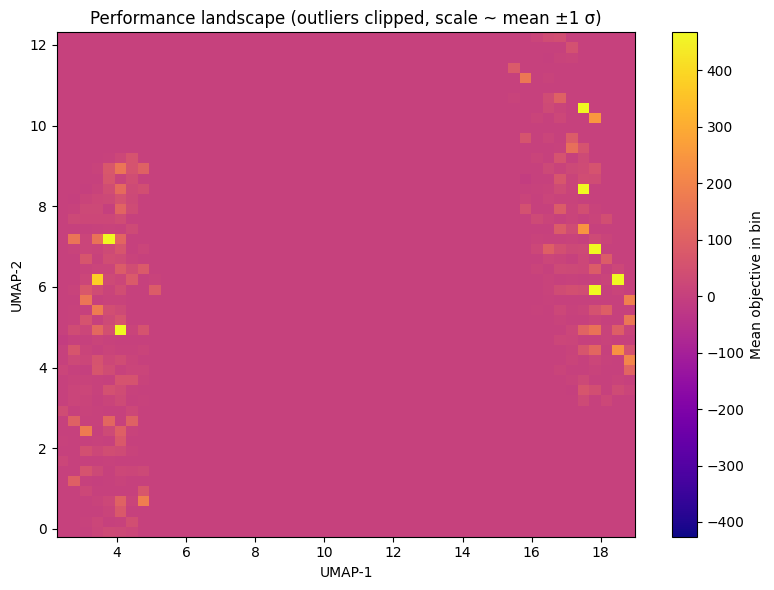

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#   filter out objective outliers (beyond ±3 σ from the mean)
# --------------------------------------------------------------
obj_mean = objs.mean()
obj_std  = objs.std()
lo, hi   = obj_mean - 3*obj_std, obj_mean + 3*obj_std
mask     = (objs >= lo) & (objs <= hi)

x_f, y_f = all_x[mask], all_y[mask]
w_f      = objs[mask]                       # colour = objective value

plt.figure(figsize=(8, 6))
hb = plt.hist2d(x_f, y_f,
                bins=50,
                weights=w_f,
                cmap="plasma",
                vmin=obj_mean - obj_std,    # <<< centre the colour bar
                vmax=obj_mean + obj_std)    #     on the mean range
plt.colorbar(hb[3], label="Mean objective in bin")
plt.title("Performance landscape (outliers clipped, scale ~ mean ±1 σ)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()
